In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib as plt
import matplotlib.pyplot as plt
import gzip
import pickle
import zipfile
import pandas as pd
import os
from tqdm import tqdm  #pip install tqdm :)
import numpy as np
from scipy.interpolate import griddata

In [2]:
optimizer_dict = {
    "SGD": optim.SGD,
    "Adagrad": optim.Adagrad,
    "Adam": optim.Adam
}

In [3]:
x = torch.rand(5, 3)
print(x)

torch.cuda.is_available()

tensor([[0.0183, 0.4314, 0.5433],
        [0.6017, 0.4753, 0.6941],
        [0.9765, 0.5078, 0.6185],
        [0.8081, 0.3791, 0.9430],
        [0.1166, 0.6464, 0.2400]])


True

In [4]:
df = pd.DataFrame(columns=["y", "X"])

In [5]:
def load_data(zip_file_path):  
    global df
    data_list = []
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.endswith('.pkl'):
                with zip_ref.open(file) as pkl_file:
                    data = pickle.load(pkl_file)
                    
                    audio_features = data['audio_data']
                    
                    if audio_features.shape[0] > 0: 
                        valence = data.get("valence")
                        data_list.append({"y": valence, "X": audio_features})
    
    # Use pd.concat to create the DataFrame
    df = pd.concat([df, pd.DataFrame(data_list)], ignore_index=True)

In [6]:
def preprocess_data(X):
    max_length = max(x.shape[0] for x in X)
    X_padded = np.array([np.pad(x, (0, max_length - x.shape[0]), mode='constant') for x in X], dtype='float32')

    # Normalize the padded data
    X_normalized = (X_padded - np.mean(X_padded)) / np.std(X_padded)
    
    return X_normalized

In [7]:
zip_file = r"C:\\Users\\Amitanshu Ghosh\\Desktop\\train.zip"
#zip_file = r"C:\Users\Danie\Downloads\train.zip"
load_data(zip_file)
df.head()

C:\Users\Amitanshu Ghosh\AppData\Local\Temp\ipykernel_9468\3939526362.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(data_list)], ignore_index=True)


,y,X
0,1.25,"[-1.0349686e-05, -8.201167e-06, 1.5248549e-05,..."
1,3.50,"[0.0004993363, 0.001089146, 0.0012895092, 0.00..."
2,3.25,"[-4.832544e-06, -8.244775e-06, -3.7053242e-06,..."
3,3.75,"[-0.00050674484, -0.0009754167, -0.0010292103,..."
4,3.50,"[2.7288927e-05, 2.9628214e-05, 8.091243e-05, 0..."


In [8]:
X = np.array(df["X"].values, dtype=object)
X = preprocess_data(X)
y = df["y"].values.astype(np.float32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Add channel dimension
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)


In [11]:
class AudioModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        torch.manual_seed(42)
        
        super(AudioModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3)
        self.batch_norm1 = nn.BatchNorm1d(8)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm1d(16)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def _get_conv_output_size(self, input_size):
        x = torch.zeros(1, 1, input_size)  # Dummy input to get the output size
        x = self.pool1(self.batch_norm1(torch.relu(self.conv1(x))))
        x = self.pool2(self.batch_norm2(torch.relu(self.conv2(x))))
        return x.shape[2]


    def forward(self, x):
        x = x.transpose(1, 2)  # Switch batch and channel dimensions for Conv1D
        x = self.pool1(self.batch_norm1(torch.relu(self.conv1(x))))
        x = self.pool2(self.batch_norm2(torch.relu(self.conv2(x))))
        x = x.transpose(1, 2)  # Switch back to batch-first format for LSTM
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Use the output of the last time step
        x = self.fc(x)
        return x

In [12]:
epochs = 5
batch_size = 8

learning_rate = 0.001
input_size = 16
hidden_size = 16
input_shape = X_train.shape[1:]

criterion = nn.MSELoss()
model = AudioModel(input_size, hidden_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

AudioModel(
  (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,))
  (batch_norm1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(1,))
  (batch_norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(16, 16, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [13]:
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [14]:
def save_model(model, optimizer, epoch, loss, file_path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(state, file_path)
    print(f"Model saved to {file_path}")

def evaluate_model(model, criterion):
    batch_size = 8
    eval_batch_size = 4  
    num_test_samples = X_test.size(0)
    num_batches = (num_test_samples + eval_batch_size - 1) // eval_batch_size

    model.eval()
    mse_loss = 0.0
    mae_loss = 0.0

    with torch.no_grad():
        for i in range(num_batches):
            start_idx = i * eval_batch_size
            end_idx = min((i + 1) * eval_batch_size, num_test_samples)
            batch_x = X_test[start_idx:end_idx]
            batch_y = y_test[start_idx:end_idx]

            batch_pred = model(batch_x).cpu().numpy()

            # Compute MSE and MAE 
            batch_mse = mean_squared_error(batch_y.cpu().numpy(), batch_pred)
            batch_mae = mean_absolute_error(batch_y.cpu().numpy(), batch_pred)

            # Accumulate losses
            mse_loss += batch_mse * (end_idx - start_idx)
            mae_loss += batch_mae * (end_idx - start_idx)

    # Compute average losses
    mse_loss /= num_test_samples
    mae_loss /= num_test_samples

    return mse_loss, mae_loss

def train_model(model, num_epochs, criterion, optimizer, save_path, optimizer_name):
    loss_per_epoch = []
    mse_per_epoch = []
    
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.size()[0])
        epoch_loss = 0
        num_batches = X_train.size()[0] // batch_size

        with tqdm(total=num_batches, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for i in range(0, X_train.size()[0], batch_size):
                indices = permutation[i:i + batch_size]
                batch_x, batch_y = X_train[indices], y_train[indices]
 
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)
        
        mse_loss, mae_loss = evaluate_model(model, criterion)
        mse_per_epoch.append(mse_loss)
        loss_per_epoch.append(epoch_loss / num_batches)


        # Saving model per epoch
        file_name = f"model_{optimizer_name}_epoch_{epoch+1}.pth"
        file_path = os.path.join(save_path, optimizer_name, file_name)
        save_model(model, optimizer, epoch+1, epoch_loss / num_batches, file_path)
        
    return loss_per_epoch, mse_per_epoch

def plot_search(results):

    
    # Extract relevant information for the heatmap
    lr_values = [result['lr'] for result in results]
    hidden_size_values = [result['hidden_size'] for result in results]
    val_loss_values = [result['loss'] for result in results]

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.scatter(lr_values, hidden_size_values, c=val_loss_values, cmap='RdYlGn', marker='o', s=100)
    plt.colorbar(heatmap, label='Validation Loss')
    plt.xscale('log')  

    
    plt.xlabel('Learning Rate')
    plt.ylabel('Hidden Size')
    plt.title('Hyperparameter Search')
    plt.grid(True)

    # Show the plot
    plt.show()



In [15]:
optimizer_names = ["SGD", "Adagrad", "Adam"]



In [16]:
save_path = "C:\\Users\\Amitanshu Ghosh\\Desktop\\test_models"
os.makedirs(save_path, exist_ok=True)

In [17]:
names = []
all_loss_evolution = []
all_mse_evolution = []

for optimizer_name in optimizer_names:
    # Directory for the optimizer
    optimizer_path = os.path.join(save_path, optimizer_name)
    os.makedirs(optimizer_path, exist_ok=True)
    
    optimizer_class = optimizer_dict[optimizer_name]
    optimizer = optimizer_class(params=model.parameters(), lr=learning_rate)

    loss_evolution, mse_evolution = train_model(model, epochs, criterion, optimizer, save_path, optimizer_name)
    all_loss_evolution.append(loss_evolution)
    all_mse_evolution.append(mse_evolution)
    
    plt.plot(mse_evolution, label=f"{optimizer_name}")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.show()

Epoch 1/5:   0%|          | 0/1055 [00:01<?, ?batch/s]


KeyboardInterrupt: 

In [18]:
def train_eval(hidden_size, learning_rate, criterion, num_epochs):
    # Create the model
    model = AudioModel(input_size, hidden_size)
    model = model.to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
    
    # Temporary save path for models during evaluation
    temp_save_path = "C:\\Users\\Amitanshu Ghosh\\Desktop\\test_model_post_train"
    
   # Does directory exist
    if not os.path.exists(temp_save_path):
        os.makedirs(temp_save_path)
    
    # Train the model
    loss_evolution, mse_evolution = train_model(model, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer, save_path=temp_save_path, optimizer_name="Adam")
    return loss_evolution[-1], mse_evolution[-1]

In [18]:
import random
# Coarse Random Search
coarse_trials = 3
num_epochs = 5
coarse_results = []

for i in range(coarse_trials):
    lr = 10.0**random.uniform(-3, -1)  # Random log-uniform sampling within the range 0.001 to 0.1
    hidden_size = int(2**random.uniform(4, 6))

    val_loss, val_mse = train_eval(hidden_size, lr, criterion, num_epochs)
    coarse_results.append({'lr': lr, 'hidden_size': hidden_size, 'loss': val_loss, 'mse': val_mse})
    print(f"{i+1}. Learning rate: {lr:.4} and hidden size: {hidden_size}")
    print(f"\tValidation mse: {val_mse:.5}\n\tValidation loss: {val_loss:.5}\n")

# Find the best parameters from coarse search
best_coarse_params = min(coarse_results, key=lambda x: x['loss'])
print(f"Best parameters found:\n - Learning rate: {best_coarse_params['lr']:.5}\n - Hidden size: {best_coarse_params['hidden_size']}\n - Validation mse: {best_coarse_params['mse']:.2}%")

Epoch 1/5: 1056batch [12:10,  1.45batch/s, loss=0.692]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_1.pth


Epoch 2/5: 1056batch [13:04,  1.35batch/s, loss=1.91]                         


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_2.pth


Epoch 3/5: 1056batch [13:39,  1.29batch/s, loss=0.906]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_3.pth


Epoch 4/5: 1056batch [13:33,  1.30batch/s, loss=0.262]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_4.pth


Epoch 5/5: 1056batch [14:36,  1.20batch/s, loss=0.718]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_5.pth
1. Learning rate: 0.09778 and hidden size: 16
	Validation mse: 0.68194
	Validation loss: 0.71194



Epoch 1/5: 1056batch [16:00,  1.10batch/s, loss=1.53]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_1.pth


Epoch 2/5: 1056batch [08:02,  2.19batch/s, loss=0.764]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_2.pth


Epoch 3/5: 1056batch [09:09,  1.92batch/s, loss=1.15]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_3.pth


Epoch 4/5: 1056batch [09:58,  1.76batch/s, loss=1.1]                         


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_4.pth


Epoch 5/5: 1056batch [07:14,  2.43batch/s, loss=0.247]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_5.pth
2. Learning rate: 0.01204 and hidden size: 26
	Validation mse: 0.68367
	Validation loss: 0.69408



Epoch 1/5: 1056batch [07:27,  2.36batch/s, loss=1.18]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_1.pth


Epoch 2/5: 1056batch [07:26,  2.37batch/s, loss=0.607]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_2.pth


Epoch 3/5: 1056batch [07:39,  2.30batch/s, loss=0.81]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_3.pth


Epoch 4/5: 1056batch [08:02,  2.19batch/s, loss=0.731]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_4.pth


Epoch 5/5: 1056batch [07:03,  2.49batch/s, loss=0.511]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_5.pth
3. Learning rate: 0.005785 and hidden size: 21
	Validation mse: 0.67705
	Validation loss: 0.71796

Best parameters found:
 - Learning rate: 0.012038
 - Hidden size: 26
 - Validation mse: 0.68%


Learning rate: 0.01083 and hidden size: 22


Epoch 1/5:   0%|          | 0/1055 [00:00<?, ?batch/s]

Epoch 1/5: 1056batch [06:45,  2.60batch/s, loss=0.514]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_1.pth


Epoch 2/5: 1056batch [06:45,  2.60batch/s, loss=0.506]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_2.pth


Epoch 3/5: 1056batch [06:37,  2.65batch/s, loss=1.44]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_3.pth


Epoch 4/5: 1056batch [06:52,  2.56batch/s, loss=1.06]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_4.pth


Epoch 5/5: 1056batch [06:46,  2.60batch/s, loss=0.37]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_5.pth
	Validation mse: 0.67709
	Validation loss: 0.694

Learning rate: 0.008957 and hidden size: 27


Epoch 1/5: 1056batch [07:08,  2.46batch/s, loss=1.47]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_1.pth


Epoch 2/5: 1056batch [07:10,  2.45batch/s, loss=1.1]                         


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_2.pth


Epoch 3/5: 1056batch [07:17,  2.41batch/s, loss=0.511]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_3.pth


Epoch 4/5: 1056batch [06:48,  2.59batch/s, loss=0.627]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_4.pth


Epoch 5/5: 1056batch [07:28,  2.36batch/s, loss=0.772]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_5.pth
	Validation mse: 0.67394
	Validation loss: 0.70175

Learning rate: 0.006617 and hidden size: 23


Epoch 1/5: 1056batch [07:08,  2.47batch/s, loss=0.675]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_1.pth


Epoch 2/5: 1056batch [07:20,  2.40batch/s, loss=1.57]                        


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_2.pth


Epoch 3/5: 1056batch [07:01,  2.50batch/s, loss=0.611]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_3.pth


Epoch 4/5: 1056batch [07:24,  2.38batch/s, loss=0.321]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_4.pth


Epoch 5/5: 1056batch [07:20,  2.40batch/s, loss=0.827]                       


Model saved to C:\Users\Amitanshu Ghosh\Desktop\test_model_post_train\Adam\model_Adam_epoch_5.pth
	Validation mse: 0.67855
	Validation loss: 0.71915

Best parameters found with coarse search:
 - Learning rate: 0.012038
 - Hidden size: 26
 - Validation mse: 0.68%
Best parameters found with fine search:
 - Learning rate: 0.010832
 - Hidden size: 22
 - Validation mse: 0.68%


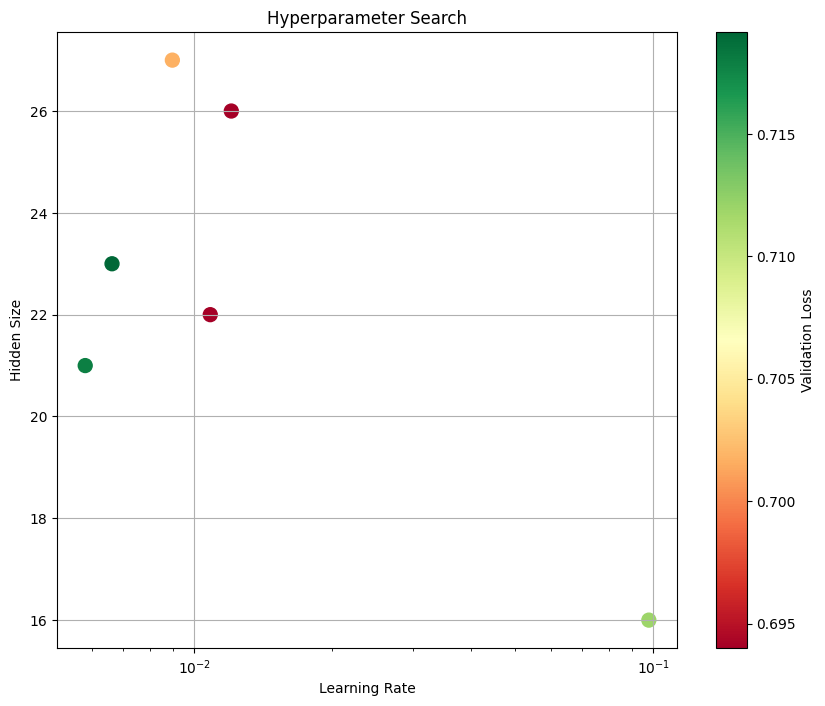

Training a model with hidden size 22 and learning rate 0.012038


NameError: name 'save_path' is not defined

In [19]:


fine_trials = 3
fine_results = []

for _ in range(fine_trials):
    lr = best_coarse_params['lr'] * 2.0**random.uniform(-1, 1)  # Fine search around the best LR
    hidden_size = int(best_coarse_params['hidden_size'] * random.uniform(0.8, 1.2))  # Fine search around the best hidden size

    print(f"Learning rate: {lr:.4} and hidden size: {hidden_size}")
    val_loss, val_mse = train_eval(hidden_size, lr, criterion, num_epochs)
    print(f"\tValidation mse: {val_mse:.5}\n\tValidation loss: {val_loss:.5}\n")
    fine_results.append({'lr': lr, 'hidden_size': hidden_size, 'loss': val_loss, 'mse': val_mse})

# Find the best parameters from fine search
best_fine_params = min(fine_results, key=lambda x: x['loss'])

print(f"Best parameters found with coarse search:\n - Learning rate: {best_coarse_params['lr']:.5}\n - Hidden size: {best_coarse_params['hidden_size']}\n - Validation mse: {best_coarse_params['mse']:.2}%")
print(f"Best parameters found with fine search:\n - Learning rate: {best_fine_params['lr']:.5}\n - Hidden size: {best_fine_params['hidden_size']}\n - Validation mse: {best_fine_params['mse']:.2}%")
plot_search(coarse_results + fine_results)

print(f"Training a model with hidden size {best_fine_params['hidden_size']} and learning rate {best_coarse_params['lr']:.5}")
model = AudioModel(input_size, best_fine_params['hidden_size'])
model = model.to(device)
optimizer = optim.Adam(params=model.parameters(), lr=best_coarse_params['lr'])  # For SGD momentum=0.9, nesterov=True)

num_epochs = 3
# Train the model
loss_evolution, mse_evolution = train_model(model=model, optimizer=optimizer, num_epochs=num_epochs, criterion=criterion, save_path=save_path, optimizer_name="Adam")
plt.plot(mse_evolution)
plt.xlabel("Epoch")
plt.ylabel("mse")
plt.show()

# Evaluate the model
eval_loss, eval_mse = evaluate_model(model, criterion)
print(f"mse on the test set: {eval_mse*100}%")

Learning rate: 0.005067 and hidden size: 21


KeyboardInterrupt: 

In [19]:
print(f"Training a model with hidden size {best_fine_params['hidden_size']} and learning rate {best_coarse_params['lr']:.5}")
model = AudioModel(input_size, best_fine_params['hidden_size'])
model = model.to(device)
optimizer = optim.Adam(params=model.parameters(), lr=best_coarse_params['lr']) #for SGD momentum=0.9, nesterov=True)
#save_path = "C:\\Users\\Amitanshu Ghosh\\Desktop\\test_model_post_train"
num_epochs = 10
# Train the model
loss_evolution, mse_evolution = train_model(model, optimizer, num_epochs=num_epochs, criterion=criterion, save_path= save_path, optimizer_name="Adam")
plt.plot(mse_evolution)
plt.xlabel("Epoch")
plt.ylabel("mse")
plt.show()

# Evaluate the model
eval_loss, eval_mse = evaluate_model(model, criterion)
print(f"mse on the test set: {eval_mse*100}%")


NameError: name 'best_fine_params' is not defined